### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

from pathlib import Path

import pandas as pd

import time

In [4]:
nr_of_experiment = 10

### Experiments data

In [5]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_7': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_3': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_6': ['Pinene', 'Benzyl benzoate'],
                        'experiment_5': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_4': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_10': ['Leucine', 'Isoleucine', 'Valine']}

In [6]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_7': [12, 8],
                        'experiment_3': [34, 12, 16, 16],
                        'experiment_6': [16, 12],
                        'experiment_5': [4, 4, 5, 5, 13],
                        'experiment_9': [4, 4, 5, 5, 13],
                        'experiment_4': [4, 4, 5, 5, 13],
                        'experiment_8': [12, 8],
                        'experiment_10': [10, 10, 8]}

In [7]:
ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_2': [0.505, 0.495],
                                    'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_6': [0.3865, 0.6135],
                                    'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_8': [0.3702, 0.6298],
                                    'experiment_10': [0.4855, 0.2427, 0.2718]}

In [8]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_6': 'experiment_6_miniperfumes',
                        'experiment_5': 'experiment_5_metabolites',
                         'experiment_7': 'experiment_7_overlapping_and_intensity_difference',
                         'experiment_9': 'experiment_9_and_4_shim',
                       'experiment_4': 'experiment_9_and_4_shim',
                        'experiment_8': 'experiment_8_different_solvents',
                        'experiment_3': 'experiment_3_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping',
                        'experiment_10': 'experiment_10_real_food_product'}

In [9]:
best_kappa_mix = [0.09, 0.05, 0.37, 0.11, 0.03, 0.06, 0.23, 0.2, 0.05, 0.27]

In [10]:
best_kappa_model = [0.08, 0.01, 0.24, 0.02, 0.09, 0.2, 0.02, 0.29, 0.02, 0.11]

### Loading the data

In [11]:
if (nr_of_experiment != 9 and nr_of_experiment != 4):
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')
else:
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_exp'+str(nr_of_experiment)+'_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')

In [12]:
how_many_components = len(components_dictionary['experiment_'+str(nr_of_experiment)])
names = ['comp' + str(i) for i in range(how_many_components)]

In [13]:
spectra = []
for i in range(how_many_components):
    if (nr_of_experiment != 9 and nr_of_experiment != 4):
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_comp' + str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))
    else:
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_exp'+str(nr_of_experiment)+ '_comp'+ str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))

In [14]:
spectra2 = []
names = []
for i in range(len(spectra)):
    spectra2.append(NMRSpectrum(confs=list(zip(spectra[i][:,0], spectra[i][:,1])), 
                                protons=protons_dictionary['experiment_'+str(nr_of_experiment)][i]))
    names.append('comp'+str(i))

spectra = spectra2
del(spectra2)
mix = NMRSpectrum(confs=list(zip(mix[:,0], mix[:,1])))

In [15]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


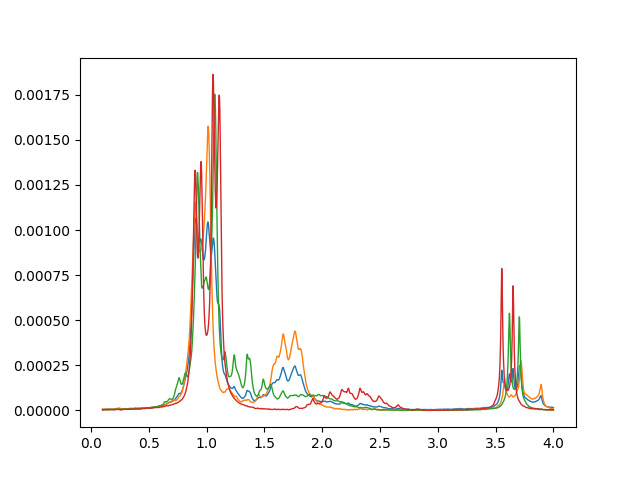

In [16]:
mix.plot(profile=True)
for sp in spectra:
    sp.plot(profile=True)

### Estimation with default kappas

In [17]:
default_MTD = 0.25
default_MTD_th = 0.22

In [18]:
start_vis = time.time()
estimation_vis = estimate_proportions(mix, spectra,
                                        MTD=default_MTD, 
                                        MTD_th=default_MTD_th,
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='area')
stop_vis = time.time()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-11-10
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.100226, 3.99994, 0), (0.100226, 3.99994, 1), (0.100226, 3.99994, 2)]
Number of chunks: 1
ChunkIDs: [0, 0, 0]
Chunk bounds: [(-0.14977400000000002, 4.2499400000000005)]
Ion currents in chunks: [1.0000000000000013]
Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.97586878723
Noise proportion in mixture's spectrum: 0.024131212769999986
Total explanation: 1.0
Noise proportion in combination of components' spectra: -0.0


In [19]:
estimation_vis['proportions']

[0.5097128645470007, 0.2588887611900003, 0.20726716149300028]

In [20]:
estimation_vis['proportion_of_noise_in_components']

0.0

In [21]:
1 - sum(estimation_vis['proportions'])

0.024131212769998744

In [22]:
print('Estimation took '+ str(stop_vis-start_vis) + ' seconds.')

Estimation took 3.2648658752441406 seconds.


In [23]:
start_con = time.time()
estimation_molar = estimate_proportions(mix, spectra,
                                        MTD=default_MTD, 
                                        MTD_th=default_MTD_th,
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='concentration')
stop_con = time.time()

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.100226, 3.99994, 0), (0.100226, 3.99994, 1), (0.100226, 3.99994, 2)]
Number of chunks: 1
ChunkIDs: [0, 0, 0]
Chunk bounds: [(-0.14977400000000002, 4.2499400000000005)]
Ion currents in chunks: [1.0000000000000013]
Deconvolving chunk 0
Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.97586878723
Noise proportion in mixture's spectrum: 0.024131212769999986
Total explanation: 1.0
Noise proportion in combination of components' spectra: -0.0


In [24]:
estimation_molar

{'proportions': [0.4959813348122909, 0.2519143664483214, 0.2521042987393878],
 'Wasserstein distance': 0.0067296071086514475}

In [25]:
print('Estimation took '+ str(stop_con-start_con) + ' seconds.')

Estimation took 3.2840094566345215 seconds.


In [26]:
# #MTD = 0.25, MTD_th = 0.22

# #1: 'Pinene', 'Benzyl benzoate'
# 0.0937, 0.9063

# #2: 'Pinene', 'Limonene'
# 0.5240, 0.4760

# #3: 'Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'
# 0.7511, 0.1059, 0.0809, 0.0621

# #4: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3165, 0.2137, 0.1341, 0.1960, 0.1397

# #5: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2113, 0.1293, 0.2018, 0.1397

# #6: 'Pinene', 'Benzyl benzoate'
# 0.3931, 0.6069

# #7: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.8428, 0.1572

# #8: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.3762, 0.6238

# #9: Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2125, 0.1333, 0.1967, 0.1395

# #10: 'Leucine', 'Isoleucine', 'Valine'
# 0.4960, 0.2519, 0.2521

#### Saving results of estimation with default parameters

In [27]:
res_vis = pd.DataFrame(np.array(estimation_vis['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis

,Leucine,Isoleucine,Valine
0,0.509713,0.258889,0.207267


In [28]:
res_con = pd.DataFrame(np.array(estimation_molar['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con

,Leucine,Isoleucine,Valine
0,0.495981,0.251914,0.252104


In [29]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_default_parameters.csv')
# else:
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area__default_parameters_exp'+str(nr_of_experiment)+'.csv')

In [30]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_default_parameters.csv')
# else:
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_default_parameters_exp'+str(nr_of_experiment)+'.csv')

In [31]:
# comp_noise = np.array(estimation_vis['proportion_of_noise_in_components']).reshape(-1)
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_comp'+ \
#                                     '_default_parameters.csv',
#                                       comp_noise)
# else:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_comp'+ \
#                                     '_exp' + str(nr_of_experiment) + \
#                                     '_default_parameters.csv',
#                                       comp_noise)

In [32]:
# mix_noise = np.array(1 - sum(estimation_vis['proportions'])).reshape(-1)
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_mix'+ \
#                                     '_default_parameters.csv',
#                                       mix_noise)
# else:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_mix'+ \
#                                     '_exp' + str(nr_of_experiment) + \
#                                     '_default_parameters.csv',
#                                       mix_noise)

### Estimation with optimal kappas

In [33]:
start_vis_opt = time.time()
estimation_vis_opt = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1],
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False),
                                        what_to_compare='area')
stop_vis_opt = time.time()

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.100226, 3.99994, 0), (0.100226, 3.99994, 1), (0.100226, 3.99994, 2)]
Number of chunks: 1
ChunkIDs: [0, 0, 0]
Chunk bounds: [(-0.16977400000000004, 4.26994)]
Ion currents in chunks: [1.0000000000000013]
Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.981092623808
Noise proportion in mixture's spectrum: 0.018907376169000005
Total explanation: 0.999999999977
Noise proportion in combination of components' spectra: 0.013189623685


In [34]:
print('Estimation took '+ str(stop_vis_opt-start_vis_opt) + ' seconds.')

Estimation took 3.33622145652771 seconds.


In [35]:
estimation_vis_opt['proportions']

[0.5036591840480007, 0.25112840451800034, 0.2263050352420003]

In [36]:
estimation_vis_opt['proportion_of_noise_in_components']

0.013189623685000018

In [37]:
start_con_opt = time.time()
estimation_molar_opt = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1], 
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='concentration')
stop_con_opt = time.time()

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.100226, 3.99994, 0), (0.100226, 3.99994, 1), (0.100226, 3.99994, 2)]
Number of chunks: 1
ChunkIDs: [0, 0, 0]
Chunk bounds: [(-0.16977400000000004, 4.26994)]
Ion currents in chunks: [1.0000000000000013]
Deconvolving chunk 0
Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.981092623808
Noise proportion in mixture's spectrum: 0.018907376169000005
Total explanation: 0.999999999977
Noise proportion in combination of components' spectra: 0.013189623685


In [38]:
print('Estimation took '+ str(stop_con_opt-start_con_opt) + ' seconds.')

Estimation took 3.209327220916748 seconds.


In [39]:
estimation_molar_opt['proportions']

[0.48537562654576666, 0.2420120798884239, 0.27261229356580946]

### Saving estimation results

In [40]:
res_vis_opt = pd.DataFrame(np.array(estimation_vis_opt['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis_opt

,Leucine,Isoleucine,Valine
0,0.503659,0.251128,0.226305


In [41]:
res_con_opt = pd.DataFrame(np.array(estimation_molar_opt['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con_opt

,Leucine,Isoleucine,Valine
0,0.485376,0.242012,0.272612


In [42]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_vis_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area.csv')
# else:
#     res_vis_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_exp'+str(nr_of_experiment)+'.csv')

In [43]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_con_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration.csv')
# else:
#     res_con_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_exp'+str(nr_of_experiment)+'.csv')